<a href="https://colab.research.google.com/github/AishaEvering/MLRegression_SeoulBikeRental/blob/main/SeoulBikeRental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

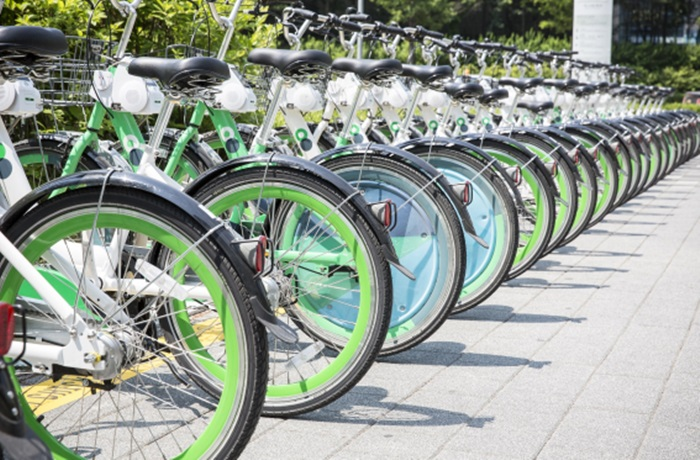

# Seasonal Bike Rental Analysis

## Project Objectives
- Identify and quantify the top 3-5 factors influencing bike rental demand in Seoul, providing actionable insights for operational decision-making.



In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error

## Load Data

In [4]:
df = pd.read_csv("/content/drive/MyDrive/SuperDataScience/SeoulBikeRental/SeoulBikeData.csv", encoding="Windows-1252")
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


**Notes:**

* More information about the features is given here, [Seoul Bike Sharing Demand](https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand).  It looks like the target variable we can use to answer the questions is "Rented Bike Count".

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

**Insights:**

*   There are 8760 rows and no missing data.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
Temperature(°C),8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
Humidity(%),8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
Wind speed (m/s),8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
Visibility (10m),8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
Dew point temperature(°C),8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
Solar Radiation (MJ/m2),8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
Rainfall(mm),8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
Snowfall (cm),8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80


**Insights:**

*   Looks like there was a great day in bike rentals with an outlier of 3556.  I will look more into this.
*   Most of the bikes are rented in around the middle of day.
*   Rainfall and Snowfal makes total sense, either stuff is falling from the sky or not.  Actually this is probably not the best way to look at the weather features.

## Exploratory Analysis

The goal is to explore the data and address the following key questions:

### Specific Questions
- What are the most significant factors influencing bike rental demand in Seoul?
- How do seasonal changes and weather conditions impact bike rental patterns?
- Are there any trends or patterns in bike rental usage during holidays or specific hours of the day?

- How does air quality (visibility) affect bike rental behavior?

### Analysis Plan

1. Time-Based Features: I will first examine how time-related features—such as Date, Hour, Season, and Holidays—correlate with bike rentals.

2. Weather Features: Next, I'll analyze the relationship between weather-related features (Temperature, Humidity, Wind Speed, Visibility, Dew Point, Solar Radiation, Rainfall, and Snowfall) and bike rentals.

3. Summary: Finally, I will integrate the insights from time-based and weather features to determine the optimal combination of factors driving bike rental demand.

Note: *Naturally, if the bikes are not functional, they cannot be rented. I will also examine the number of non-functional days but having functional bikes it an obvious insight.*


### Time-Based Features

In [7]:
# converting data string to datetime type
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


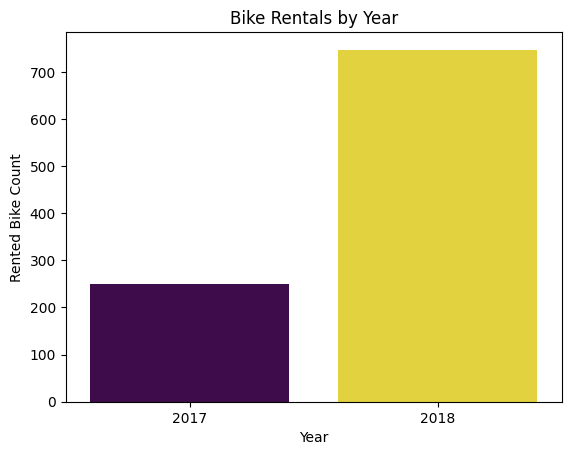

In [8]:
df['year'] = df['Date'].dt.year

sns.barplot(data=df, x='year', y="Rented Bike Count", hue='year', legend=False, errorbar=None, palette='viridis')

plt.xlabel('Year')
plt.ylabel('Rented Bike Count')
plt.title('Bike Rentals by Year')
plt.show()

**Insights:**

*   The data ranges from 2017 - 2018
*   A majority of the data was collected in 2018.



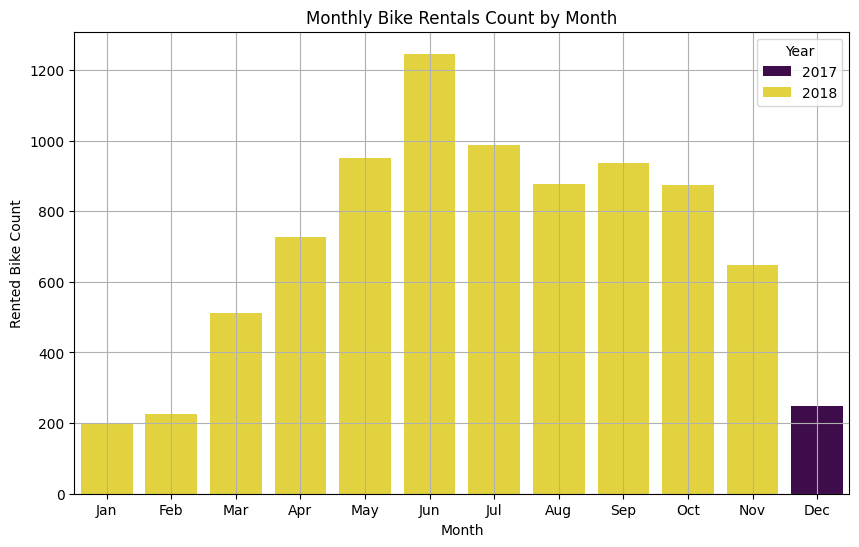

In [9]:
df['month'] = df['Date'].dt.month

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='month', y='Rented Bike Count', hue='year', errorbar=None, palette='viridis')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Rented Bike Count')
plt.title('Monthly Bike Rentals Count by Month')

# Set x-axis ticks to show month names
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.legend(title='Year')
plt.grid(True)
plt.show()


 **Insights:**

*   More bikes are rented in the summer and fall months.
*   There isn't a full year of data available, but the data in 2017 will give us an indication of how the rentals might perform at the end of the year.

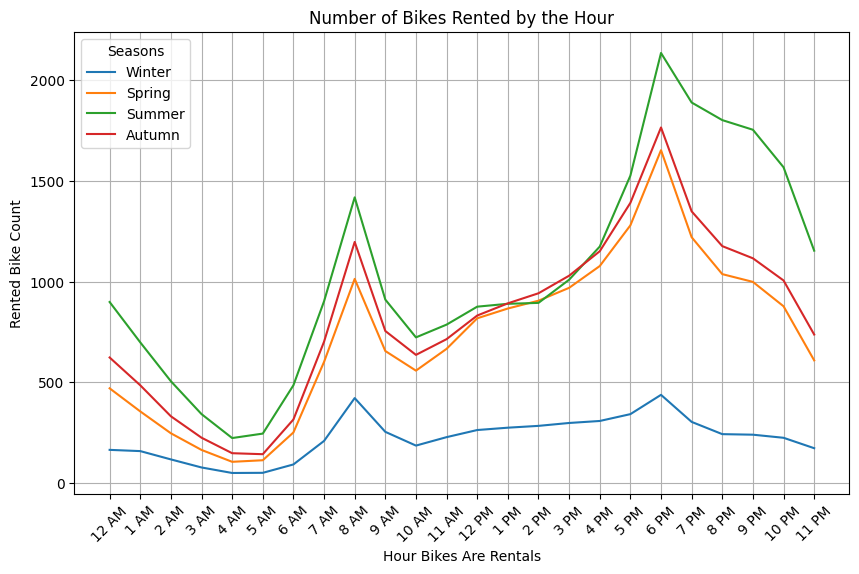

In [10]:
plt.figure(figsize=(10, 6))

palette = sns.color_palette("mako_r", 12)
sns.lineplot(data=df, x='Hour', y='Rented Bike Count', hue='Seasons', errorbar=None)

plt.title('Number of Bikes Rented by the Hour')
plt.xlabel('Hour Bikes Are Rentals')
plt.ylabel('Rented Bike Count')

# format x-axis to 12-hour time
plt.xticks(ticks=range(0, 24), labels=[f'{hour % 12 or 12} {"AM" if hour < 12 else "PM"}' for hour in range(24)], rotation=45)


plt.grid(True)
plt.show()


**Insights:**

*  Most popular time to rent bikes is ~6PM in the summer months.
*  Second most popular time is ~8AM in the summber months.
*  Least popular times is around 3-5 AM in the winter months.
*  The winter bike rental count is far below all the other seasons.

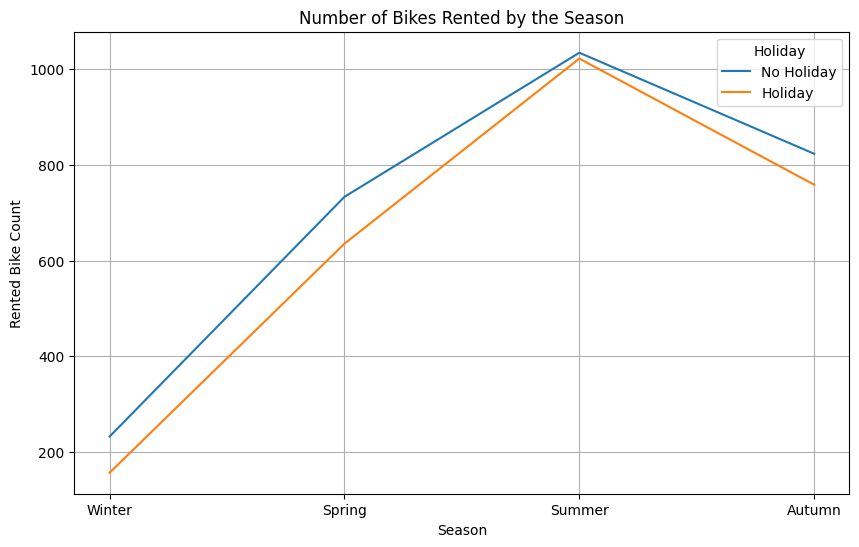

In [11]:
plt.figure(figsize=(10, 6))

palette = sns.color_palette("mako_r", 12)
sns.lineplot(data=df, x='Seasons', y='Rented Bike Count', hue='Holiday', errorbar=None)

plt.title('Number of Bikes Rented by the Season')
plt.xlabel('Season')
plt.ylabel('Rented Bike Count')

plt.grid(True)
plt.show()

**Insights:**

*  As suspected Bike Rentals spike in the summer on both non-holidays and holidays.
*  Non-holidays generally have a higher rental count.
*  Bike rentals take a significant drop in the winter months for non-holidays and holidays, which sounds right.

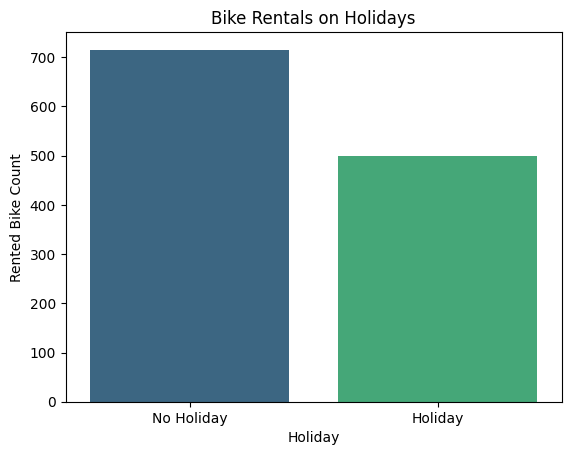

In [12]:
sns.barplot(data=df, x='Holiday', y="Rented Bike Count", hue="Holiday", legend=False, errorbar=None, palette='viridis')

plt.xlabel('Holiday')
plt.ylabel('Rented Bike Count')
plt.title('Bike Rentals on Holidays')
plt.show()

Insights:

More bikes on rented on non-holidays but that could be because there are less hollidays than non-holidays.

### Weather Features

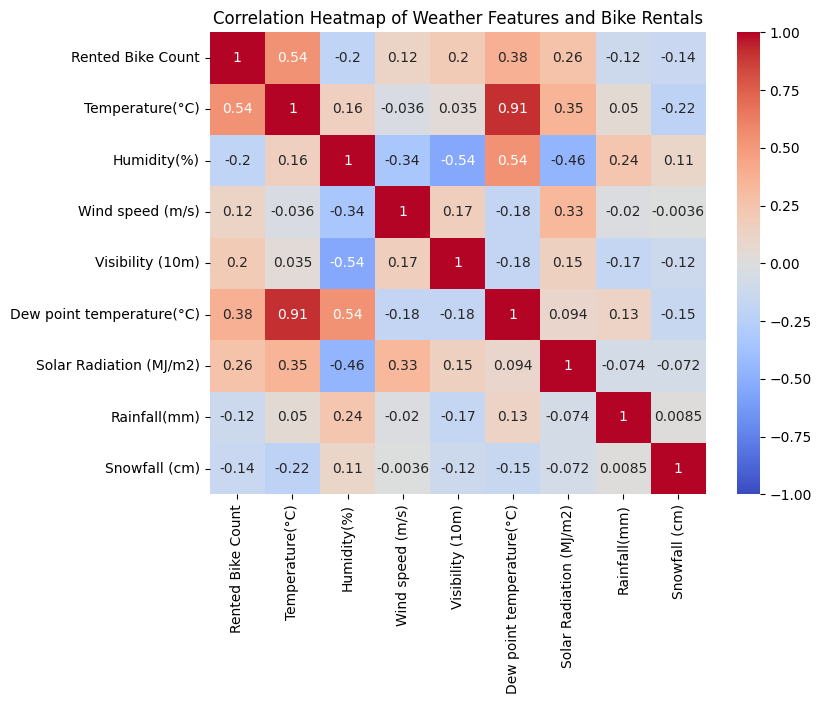

In [13]:
weather_features = ['Rented Bike Count', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)','Visibility (10m)',
                    'Dew point temperature(°C)','Solar Radiation (MJ/m2)',
                    'Rainfall(mm)', 'Snowfall (cm)']

df_weather = df[weather_features]

plt.figure(figsize=(8, 6))

sns.heatmap(df_weather.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Weather Features and Bike Rentals')
plt.show()

**Insights:**

*  Amongst the weather features Temperature has the highest correlation with Bike Retals followed by Dew Point, Solar Radiation, Humidity and Visibility.

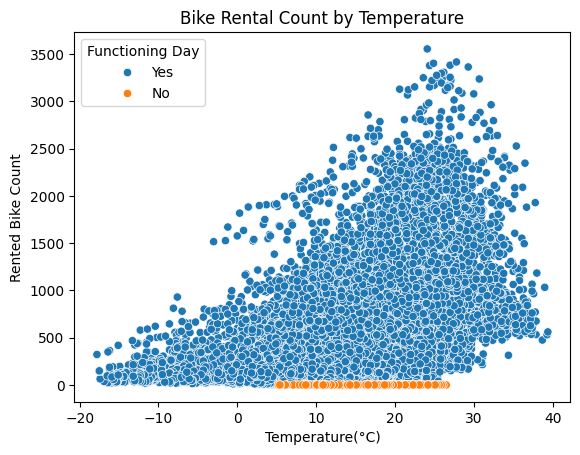

In [14]:
sns.scatterplot(data=df, x="Temperature(°C)", y="Rented Bike Count", hue="Functioning Day")
plt.title('Bike Rental Count by Temperature')
plt.show()

**Insights:**

*  The higher the temperature is the higher Bike Rentals.
*  Even on functioning days, low temperatures decreased bike rentals close to zero.

In [15]:
dew_point_bins = [-float('inf'), -10, 15, float('inf')]
solar_radiation_bins = [-float('inf'), 1.5, 2.5, float('inf')]
humidity_bins = [-float('inf'), 33, 66, float('inf')]
visibility_bins = [-float('inf'), 1000, 1500, float('inf')]

df_weather = df.copy()

df_weather['Dew Point Binned'] = pd.cut(df['Dew point temperature(°C)'], bins=dew_point_bins, labels=['Low', 'Medium', 'High'])
df_weather['Solar Radiation Binned'] = pd.cut(df['Solar Radiation (MJ/m2)'], bins=solar_radiation_bins, labels=['Low', 'Medium', 'High'])
df_weather['Humidity Binned'] = pd.cut(df['Humidity(%)'], bins=humidity_bins, labels=['Low', 'Medium', 'High'])
df_weather['Visibility Binned'] = pd.cut(df['Visibility (10m)'], bins=visibility_bins, labels=['Low', 'Medium', 'High'])

# getting the average bike rentals
dew_point_avg = df_weather.groupby('Dew Point Binned', observed=True)['Rented Bike Count'].mean()
solar_radiation_avg = df_weather.groupby('Solar Radiation Binned', observed=True)['Rented Bike Count'].mean()
humidity_avg = df_weather.groupby('Humidity Binned', observed=True)['Rented Bike Count'].mean()
visibility_avg = df_weather.groupby('Visibility Binned', observed=True)['Rented Bike Count'].mean()

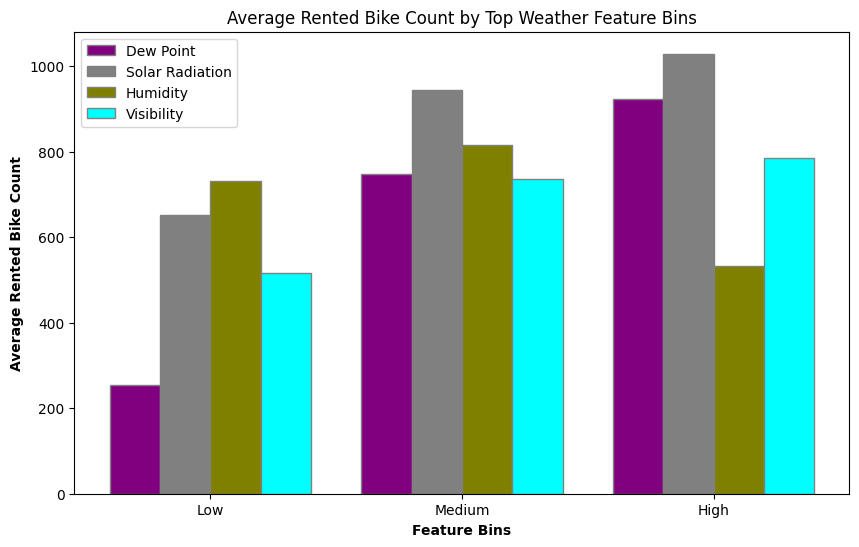

In [16]:
# defining positions for bars
bar_width = 0.2
r1 = np.arange(len(dew_point_avg))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]


plt.figure(figsize=(10, 6))

plt.bar(r1, dew_point_avg, color='purple', width=bar_width, edgecolor='grey', label='Dew Point')
plt.bar(r2, solar_radiation_avg, color='gray', width=bar_width, edgecolor='grey', label='Solar Radiation')
plt.bar(r3, humidity_avg, color='olive', width=bar_width, edgecolor='grey', label='Humidity')
plt.bar(r4, visibility_avg, color='cyan', width=bar_width, edgecolor='grey', label='Visibility')


plt.xlabel('Feature Bins', fontweight='bold')
plt.ylabel('Average Rented Bike Count', fontweight='bold')
plt.title('Average Rented Bike Count by Top Weather Feature Bins')
plt.xticks([r + bar_width*1.5 for r in range(len(dew_point_avg))], ['Low', 'Medium', 'High'])

plt.legend()
plt.show()


**Insights:**

Amongst the top correlated weather features besides temparature...
*  High (> 15) Dew Point
*  High (> 2.5) Solar Radiation a.k.a Sunny Days
*  Medium (<= 33 and < 66) Humidity
*  High (> 1500) Visibility

lead to **higher** bike rentals *on average*.

Also the following...
*  Low (< -10) Dew Point
*  Low (< 1.5) Solar Radiation a.k.a Sunny Days
*  High (> 66) Humidity
*  Low (< 1000) Visibility

lead to **lower** bike rentals *on average*.

In [17]:
snowfall_bins = [-float('inf'), 4, 6, float('inf')]
rainfall_bins = [-float('inf'), 11, 18, float('inf')]
windspeed_bins = [-float('inf'), 1.5, 5.4, float('inf')]

df_weather = df.copy()

# binning the top weather correlations beside temperature
df_weather['Snowfall Binned'] = pd.cut(df['Snowfall (cm)'], bins=snowfall_bins, labels=['Low', 'Medium', 'High'])
df_weather['Rainfall Binned'] = pd.cut(df['Rainfall(mm)'], bins=rainfall_bins, labels=['Low', 'Medium', 'High'])
df_weather['Windspeed Binned'] = pd.cut(df['Wind speed (m/s)'], bins=windspeed_bins, labels=['Low', 'Medium', 'High'])

# getting the average bike rentals
snowfall_avg = df_weather.groupby('Snowfall Binned', observed=True)['Rented Bike Count'].mean()
rainfall_avg = df_weather.groupby('Rainfall Binned', observed=True)['Rented Bike Count'].mean()
windspeed_avg = df_weather.groupby('Windspeed Binned', observed=True)['Rented Bike Count'].mean()

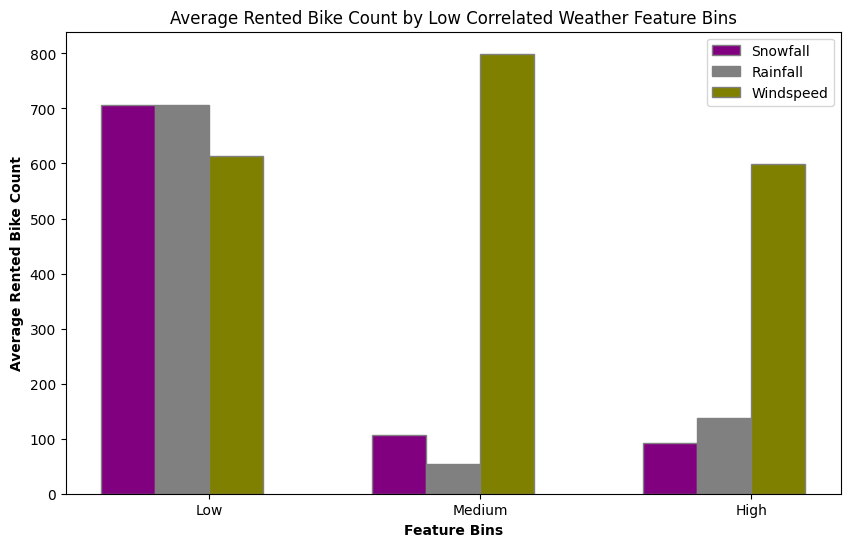

In [18]:
# defining positions for bars
bar_width = 0.2
r1 = np.arange(len(dew_point_avg))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]


plt.figure(figsize=(10, 6))

plt.bar(r1, snowfall_avg, color='purple', width=bar_width, edgecolor='grey', label='Snowfall')
plt.bar(r2, rainfall_avg, color='gray', width=bar_width, edgecolor='grey', label='Rainfall')
plt.bar(r3, windspeed_avg, color='olive', width=bar_width, edgecolor='grey', label='Windspeed')


# Adding labels
plt.xlabel('Feature Bins', fontweight='bold')
plt.ylabel('Average Rented Bike Count', fontweight='bold')
plt.title('Average Rented Bike Count by Low Correlated Weather Feature Bins')
plt.xticks([r + bar_width*1.5 for r in range(len(dew_point_avg))], ['Low', 'Medium', 'High'])

plt.legend()
plt.show()


**Insights:**

Amongst the low correlated weather features besides temparature...
*  Low (< 4) Snowfall
*  Low (< 11) Rainfall
*  Medium (<= 1.5 and < 5.4) Windspeed

lead to **higher** bike rentals *on average*.

Also the following...
*  High (> 6) Snowfall
*  Medium (<= 11 and < 18) Rainfall
*  High (> 5.4) Windspeed

lead to **lower** bike rentals *on average*.

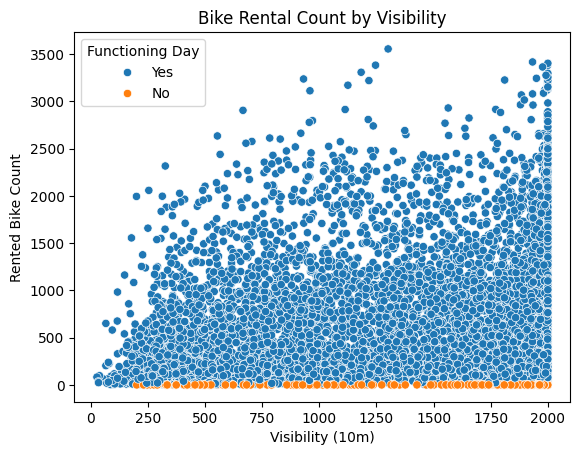

In [19]:
sns.scatterplot(data=df, x="Visibility (10m)", y="Rented Bike Count", hue="Functioning Day")
plt.title('Bike Rental Count by Visibility')
plt.show()

Insights:

There is a weak correlation between Bike Rentals and Visibility.  This may be more to do with the other weather factors and less to do with visibility specifically. For instance...

* Visibility has a **negative correlation** with **Humidity**: As humidity increases, visibility tends to decrease, which is common in foggy or misty conditions.
* Humidity has a **high correlation** with **Dew Point**: Higher humidity often corresponds to a higher dew point, as the air is holding more moisture.
* Dew Point has an **extremely high correlation** with **Temperature**: Dew point is a function of temperature; warmer air can hold more moisture, which increases the dew point.
* Temperature is **positively correlated** with **Bike Rentals**: Warmer weather generally encourages more outdoor activities, including bike rentals.

Visibility → Humidity → Dew Point → Temperature → Bike Rentals



## Feature Engineering

*  Taking a look at the distributions
*   Dropping Functioning Day
*   Adding Weekend feature
*   Adding Weekday feature
*   Dropping Date, we have year, month, holiday, weekend, weekday, season features
*   Make Hour a category of time of day
    - Early Morning: 12:00 AM - 6:00 AM
    - Morning: 6:01 AM - 12:00 PM
    - Afternoon: 12:01 PM - 5:00 PM
    - Evening: 5:01 PM - 9:00 PM
    - Night: 9:01 PM - 11:59 PM
* Dropping Hour



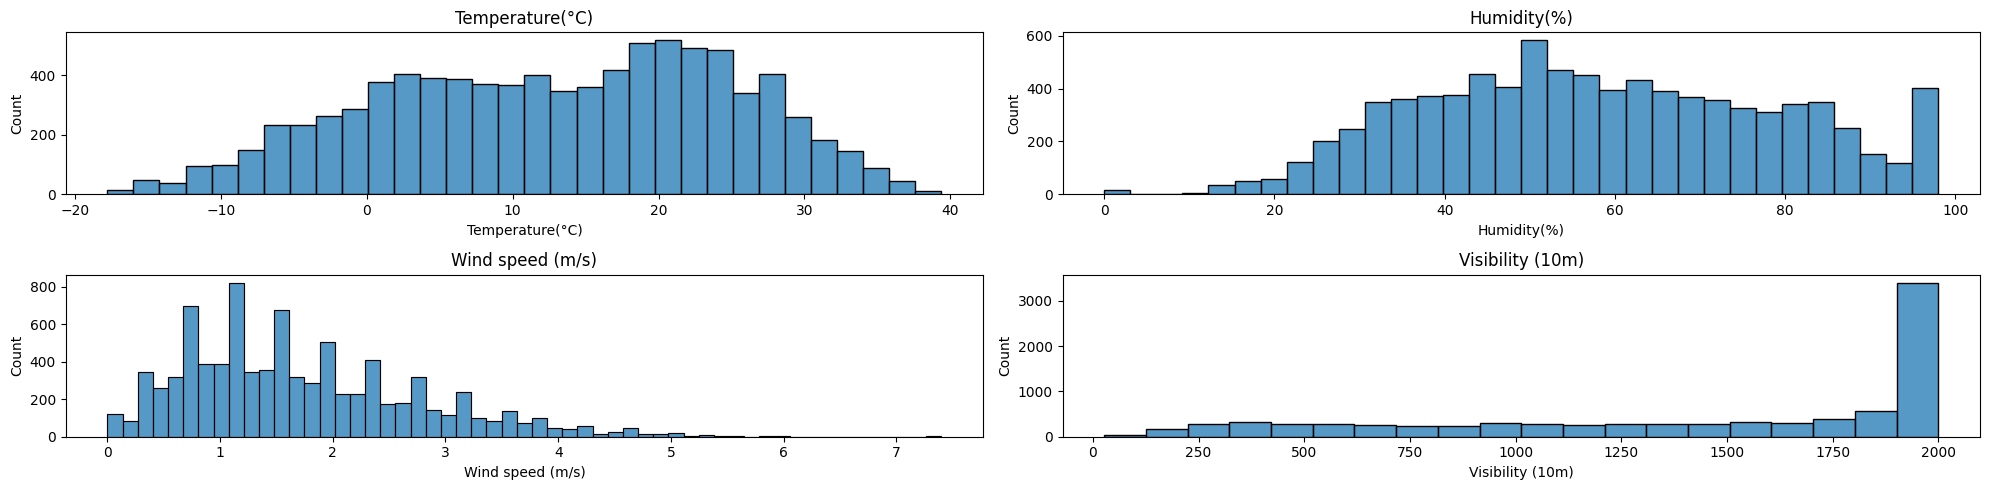

In [20]:
fig, axes = plt.subplots(2,2,figsize=(20,5))
sns.histplot(df['Temperature(°C)'], ax=axes[0,0]).set(title="Temperature(°C)")
sns.histplot(df['Humidity(%)'], ax=axes[0,1]).set(title="Humidity(%)")
sns.histplot(df['Wind speed (m/s)'], ax=axes[1,0]).set(title="Wind speed (m/s)")
sns.histplot(df['Visibility (10m)'], ax=axes[1,1]).set(title="Visibility (10m)")
plt.tight_layout()
plt.show()

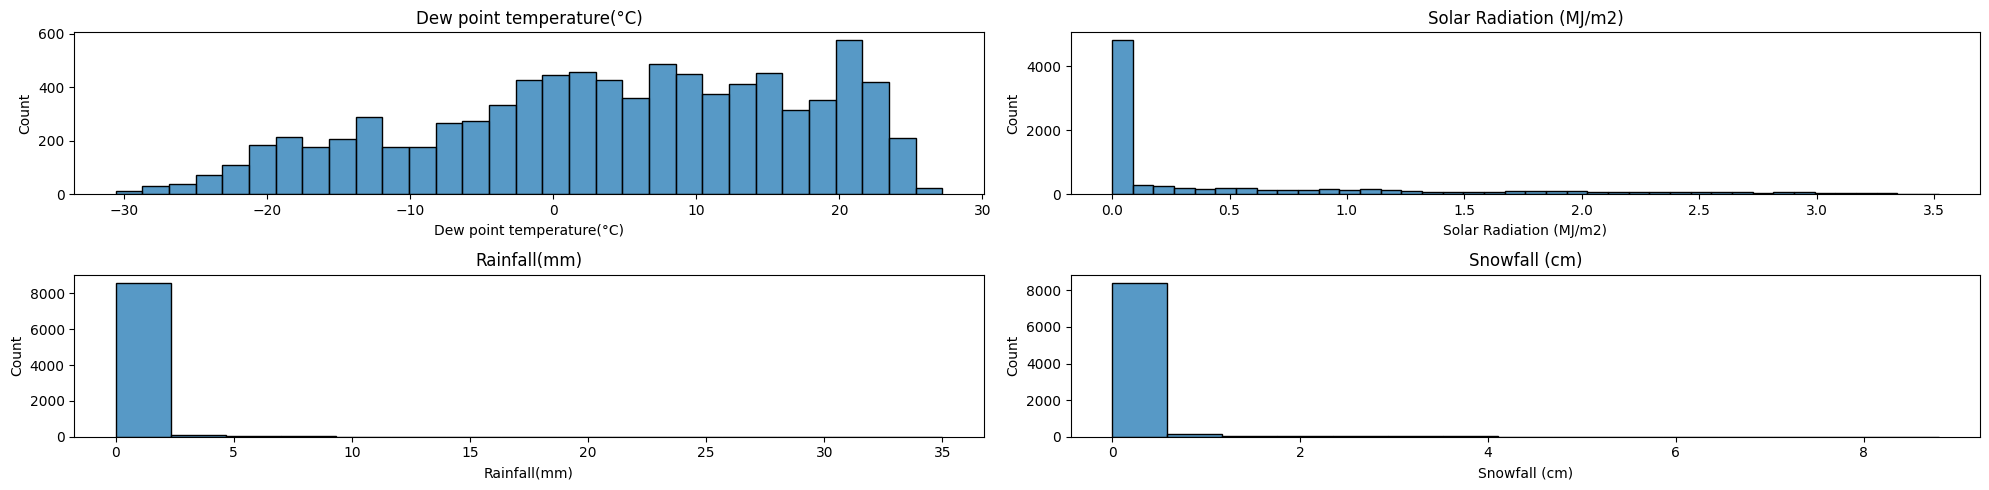

In [21]:
fig, axes = plt.subplots(2,2,figsize=(20,5))
sns.histplot(df['Dew point temperature(°C)'], ax=axes[0,0]).set(title="Dew point temperature(°C)")
sns.histplot(df['Solar Radiation (MJ/m2)'], ax=axes[0,1]).set(title="Solar Radiation (MJ/m2)")
sns.histplot(df['Rainfall(mm)'], ax=axes[1,0]).set(title="Rainfall(mm)")
sns.histplot(df['Snowfall (cm)'], ax=axes[1,1]).set(title="Snowfall (cm)")
plt.tight_layout()
plt.show()

*   Wind speed, Solar Radiation, Rainfall, and Snowfall are right skewed.  I will apply log transformation in the pipeline for this.
*   Visibility is heavily left skewed, maybe I can handle this with Robust scaler.  Not sure yet.

In [109]:
# dropping
df_eng = df.drop(columns=['Date', 'Functioning Day', 'Hour'])
df_eng.head()

,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,year,month
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,2017,12
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,2017,12


In [110]:
# create weekend and weekday features
df_eng['Weekday'] = df['Date'].dt.weekday
df_eng['Weekend'] = df['Date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
df_eng.head()

,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,year,month,Weekday,Weekend
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0


In [111]:
# categorize hour
def categorize_hour(hour):
    if 0 <= hour < 6:
        return 'Early Morning'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_eng['TimeOfDay'] = df['Hour'].apply(categorize_hour)
df_eng.head()

,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,year,month,Weekday,Weekend,TimeOfDay
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning


## Data Preperation
*   Encoding
  - Holiday
  - Seasons
  - TimeOfDay
* Creating X and y
* Splitting data
* Creating pipelines

In [112]:
df_eng.head()

,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,year,month,Weekday,Weekend,TimeOfDay
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning


In [113]:
X = df_eng.drop('Rented Bike Count', axis=1)
y = df_eng['Rented Bike Count']
X.shape, y.shape

((8760, 15), (8760,))

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7008, 15), (7008,), (1752, 15), (1752,))

In [115]:
df_eng.head()

,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,year,month,Weekday,Weekend,TimeOfDay
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,4,0,Early Morning


In [116]:
# Create list of num cols
right_skewed_num_cols = ['Wind speed (m/s)','Solar Radiation (MJ/m2)', 'Rainfall(mm)','Snowfall (cm)']
left_skewed_num_cols = ['Visibility (10m)']
normal_num_cols = ['Temperature(°C)','Humidity(%)','Dew point temperature(°C)']

cat_cols = ['Seasons', 'Holiday', 'TimeOfDay']


# Create Numeric Transformer
rigth_skewed_numeric_transformer = Pipeline(steps=[
    ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', StandardScaler())
])

left_transformer = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create Column Transformer
preprocessor = ColumnTransformer(
    transformers = [
        ('righ_num', numeric_transformer, right_skewed_num_cols),
        ('lef_num', numeric_transformer, left_skewed_num_cols),
        ('norm_num', numeric_transformer, normal_num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ],
    remainder='passthrough'  # Pass through any columns not specified in transformers
)

In [92]:
# holds all the metrics
metrics = {}

## Train  Models

### Base (Linear Regression) Model Pipeline





In [93]:
# Define Pipeline
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Train the model
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('righ_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Wind speed (m/s)',
                                                   'Solar Radiation (MJ/m2)',
                                                   'Rainfall(mm)',
                                                   'Snowfall (cm)']),
                                                 ('norm_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Temperature(°C)',
                                                   'Humidity(%)',
                                                   'Dew point '
                                                   'temperature(°C)']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Seasons', 'Holiday',
                                                   'TimeOfDay'])])),
                ('model', LinearRegression())])

In [94]:
def get_metrics(pipeline, model_name):

  # get predictions
  y_preds = pipeline.predict(X_test)

  # get rsme (lower the better) and r2 (the higher the better)
  rmse = np.sqrt(mean_squared_error(y_test, y_preds))
  r2 = r2_score(y_test, y_preds)

  # how well the model performs on training data
  scoring = make_scorer(mean_squared_error, squared=False)
  cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=scoring)
  avg_cv_rmse = cv_scores.mean()

  # store metrics
  model_metrics = {
    "model": model_name,
    "rmse": rmse,
    "cv_avg_rmse": avg_cv_rmse,
    "r2": r2,
  }

  metrics[model_name] = model_metrics

  # print them
  print(f"Model: {model_name}")
  print(f"RMSE: {rmse:.2f}")
  print(f"CV Avg RMSE: {avg_cv_rmse:.2f}")
  print(f"R² Score: {r2:.2f}")

  return y_preds

In [95]:
y_preds = get_metrics(baseline_pipeline, "linear_regression")

Model: linear_regression
RMSE: 442.12
CV Avg RMSE: 436.45
R² Score: 0.53


In [96]:
def plot_pred_vs_actual(y_preds, title:str) -> None:
  plt.scatter(y_test, y_preds, alpha=0.5)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
  plt.xlabel('Actual values')
  plt.ylabel('Predicted values')
  plt.title(title)
  plt.show()

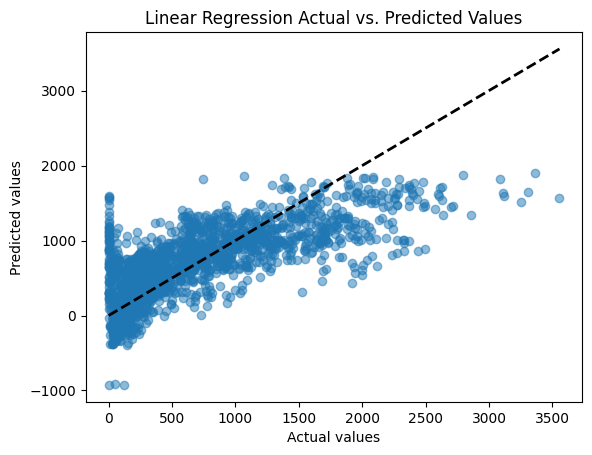

In [97]:
plot_pred_vs_actual(y_preds, "Linear Regression Actual vs. Predicted Values")

In [98]:
def transform_features(pipeline, X):
    return pipeline.named_steps['preprocessor'].transform(X)

def plot_feature_importance(pipeline, model_name):
  # Extract the model from the pipeline
  model = pipeline.named_steps['model']

  useCoef = hasattr(model, 'coef_')

  # Check if the model is SVR
  if isinstance(model, SVR):
    # Calculate permutation importance
    X_test_transformed = transform_features(pipeline, X_test)
    result = permutation_importance(model, X_test_transformed, y_test, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')
    importances = result.importances_mean
    feature_names = X.columns
  else:
    # For models with direct feature importance
    importances = model.coef_.flatten() if useCoef else model.feature_importances_
    feature_names = X.columns

  feature_importances = dict(zip(X.columns, importances))

  # Sort features by importance
  sorted_features = sorted(feature_importances.items(), key=lambda x: np.abs(x[1]), reverse=True)

  # Extract sorted feature names and their corresponding coefficients
  sorted_feature_names, sorted_coefficients = zip(*sorted_features)

  # Plot the feature importances
  plt.figure(figsize=(6, 4))
  plt.barh(sorted_feature_names, sorted_coefficients, color='skyblue')
  plt.xlabel(f'{"Coefficient" if useCoef else "Importance"} Value')
  plt.title(f'Feature Importance in {model_name}')
  plt.gca().invert_yaxis()  # Highest importance at the top
  plt.show()


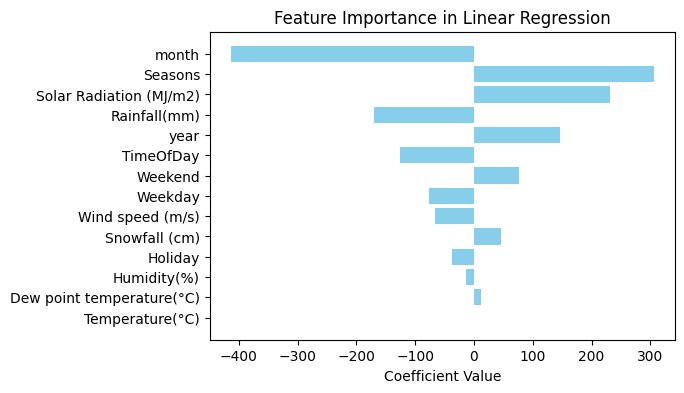

In [99]:
plot_feature_importance(baseline_pipeline, "Linear Regression")

Just as I noticed in the EDA the how sunny it is, the season which goes with the month, snow and rainfall or some of the most important features.  I feel like since there is one dominant year it doens't really count.

### ElasticNet Model Pipeline

In [100]:
# Define Pipeline
elasticnet_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet(alpha=1.0, l1_ratio=0.5))
])

# Train the model
elasticnet_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('righ_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Wind speed (m/s)',
                                                   'Solar Radiation (MJ/m2)',
                                                   'Rainfall(mm)',
                                                   'Snowfall (cm)']),
                                                 ('norm_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Temperature(°C)',
                                                   'Humidity(%)',
                                                   'Dew point '
                                                   'temperature(°C)']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Seasons', 'Holiday',
                                                   'TimeOfDay'])])),
                ('model', ElasticNet())])

In [101]:
y_preds = get_metrics(elasticnet_pipeline, "elasticnet")

Model: elasticnet
RMSE: 486.09
CV Avg RMSE: 488.43
R² Score: 0.43


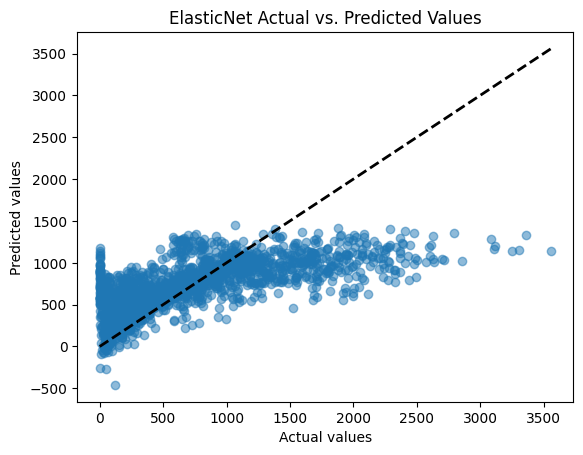

In [102]:
plot_pred_vs_actual(y_preds, "ElasticNet Actual vs. Predicted Values")

Booooooo!!!

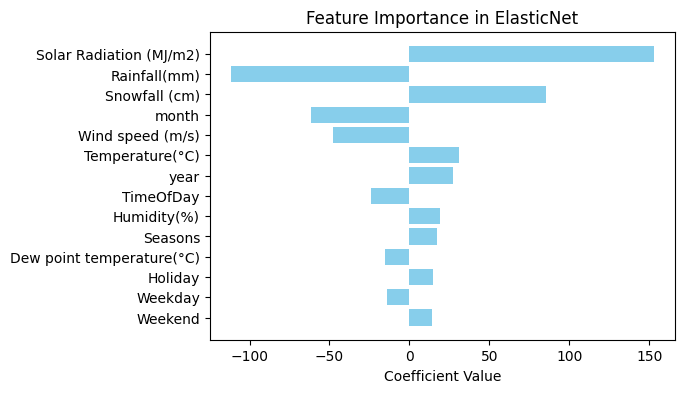

In [103]:
plot_feature_importance(elasticnet_pipeline, "ElasticNet")

### SVR Model Pipeline

In [104]:
# Define Pipeline
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVR(kernel='rbf', C=100, gamma=0.1))
])

# Train the model
svr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('righ_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Wind speed (m/s)',
                                                   'Solar Radiation (MJ/m2)',
                                                   'Rainfall(mm)',
                                                   'Snowfall (cm)']),
                                                 ('norm_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Temperature(°C)',
                                                   'Humidity(%)',
                                                   'Dew point '
                                                   'temperature(°C)']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Seasons', 'Holiday',
                                                   'TimeOfDay'])])),
                ('model', SVR(C=100, gamma=0.1))])

In [105]:
y_preds = get_metrics(svr_pipeline, "svr")

Model: svr
RMSE: 346.46
CV Avg RMSE: 336.56
R² Score: 0.71


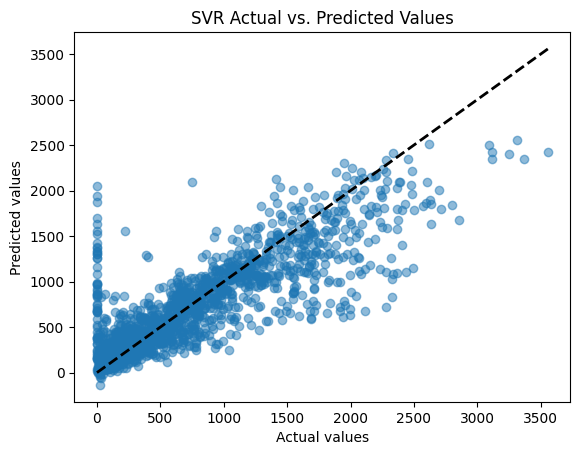

In [106]:
plot_pred_vs_actual(y_preds, "SVR Actual vs. Predicted Values")

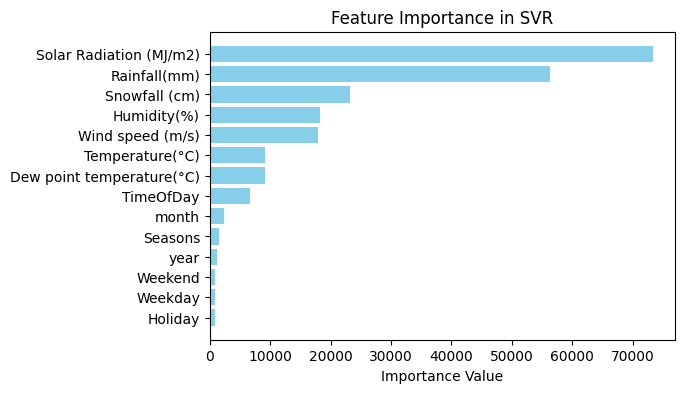

In [107]:
plot_feature_importance(svr_pipeline, "SVR")

## Train Ensemble Models

### Random Forest Regressor Pipeline

In [50]:
# Define Pipeline
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42))
])

# Train the model
random_forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('righ_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Wind speed (m/s)',
                                                   'Solar Radiation (MJ/m2)',
                                                   'Rainfall(mm)',
                                                   'Snowfall (cm)']),
                                                 ('lef_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Visibility (10m)']),
                                                 ('norm_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Temperature(°C)',
                                                   'Humidity(%)',
                                                   'Dew point '
                                                   'temperature(°C)']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Seasons', 'Holiday',
                                                   'TimeOfDay'])])),
                ('model',
                 RandomForestRegressor(max_depth=10, n_estimators=500,
                                       random_state=42))])

In [51]:
y_preds = get_metrics(random_forest_pipeline, "randomforestregressor")

Model: randomforestregressor
RMSE: 324.89
CV Avg RMSE: 321.01
R² Score: 0.75


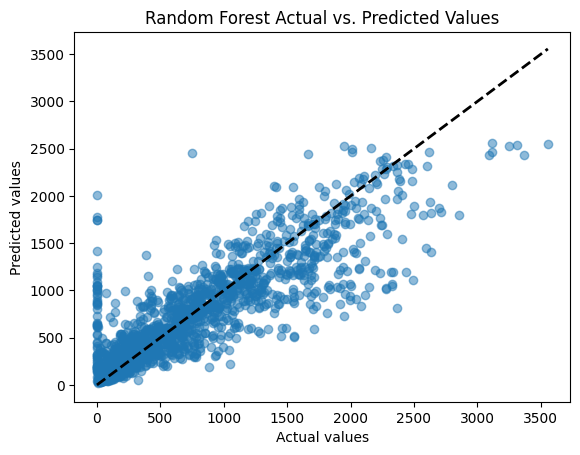

In [52]:
plot_pred_vs_actual(y_preds, "Random Forest Actual vs. Predicted Values")

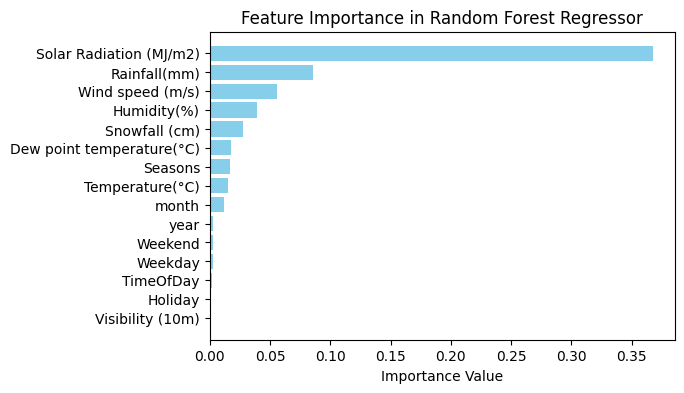

In [53]:
plot_feature_importance(random_forest_pipeline, "Random Forest Regressor")

### XG Boost Regressor Pipeline

In [55]:
# Define Pipeline
xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=500, random_state=42))
])

# Train the model
xgboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('righ_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Wind speed (m/s)',
                                                   'Solar Radiation (MJ/m2)',
                                                   'Rainfall(mm)',
                                                   'Snowfall (cm)']),
                                                 ('lef_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Visibility (10m)']),
                                                 ('norm_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [56]:
y_preds = get_metrics(xgboost_pipeline, "xgboost")

Model: xgboost
RMSE: 295.09
CV Avg RMSE: 299.13
R² Score: 0.79


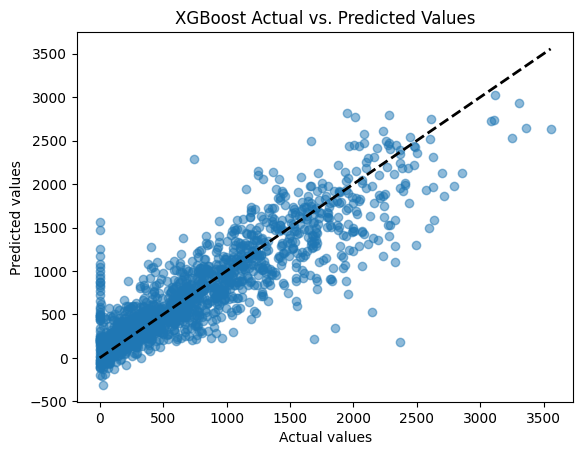

In [57]:
plot_pred_vs_actual(y_preds, "XGBoost Actual vs. Predicted Values")

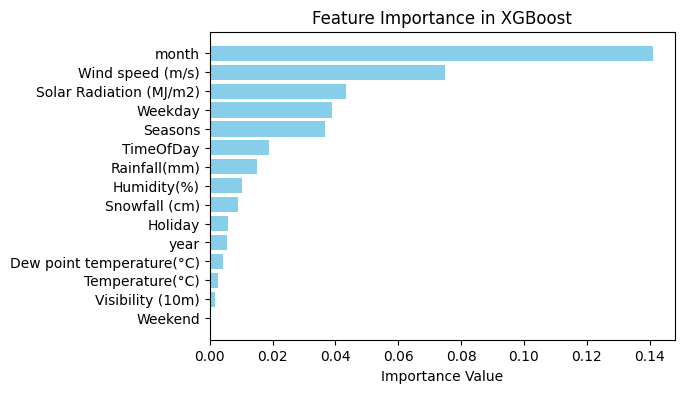

In [58]:
plot_feature_importance(xgboost_pipeline, "XGBoost")

Interesting the sun is third here with month being the most important feature.

## Getting Best Params of Top Performers

In [59]:
pd.DataFrame(metrics)

,linear_regression,elasticnet,svr,randomforestregressor,xgboost
model,linear_regression,elasticnet,svr,randomforestregressor,xgboost
rmse,442.093852,485.566753,346.275606,324.892605,295.094892
cv_avg_rmse,436.56901,487.785106,336.379826,321.01195,299.127843
r2,0.530904,0.434112,0.71221,0.746655,0.790995


Looks like XGBoost and Random Forest are the top performers with the higher R2 and the lower rmse

### Random Forest Regressor Best Params

In [60]:
param_dist = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__max_depth': [10, 20, 30, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}


random_search = RandomizedSearchCV(estimator=random_forest_pipeline,
                                   param_distributions=param_dist,
                                   n_iter=10, cv=5, random_state=42,
                                   n_jobs=-1, scoring='neg_mean_squared_error')

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

best_rf_model = random_search.best_estimator_

Best Parameters: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 30, 'model__bootstrap': True}


In [118]:
y_preds = get_metrics(best_rf_model, "best_rf_model")

Model: best_rf_model
RMSE: 306.48
CV Avg RMSE: 302.45
R² Score: 0.77


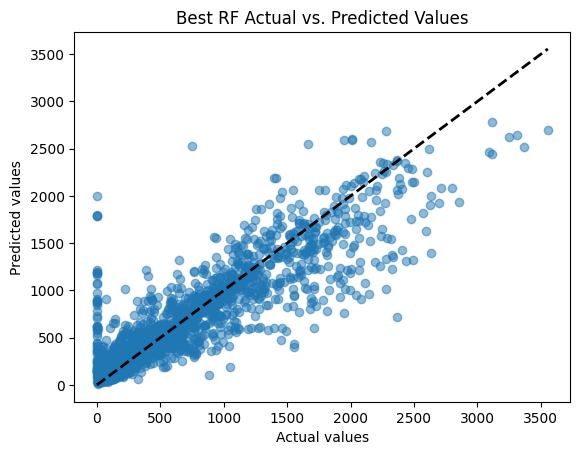

In [119]:
plot_pred_vs_actual(y_preds, "Best RF Actual vs. Predicted Values")

### XGBoost Best Params

In [125]:
param_dist = {
    'model__n_estimators': [300, 500, 800],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.3],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 1, 5],
    'model__min_child_weight': [1, 3, 5]
}

random_search = RandomizedSearchCV(estimator=xgboost_pipeline,
                                   param_distributions=param_dist,
                                   n_iter=50, cv=5, random_state=42,
                                   n_jobs=-1, scoring='neg_mean_squared_error')

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

best_xgboost_model = random_search.best_estimator_

Best Parameters: {'model__subsample': 0.8, 'model__n_estimators': 300, 'model__min_child_weight': 3, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__gamma': 1, 'model__colsample_bytree': 1.0}


In [126]:
y_preds = get_metrics(best_xgboost_model, "best_xgboost_model")

Model: best_xgboost_model
RMSE: 287.83
CV Avg RMSE: 285.46
R² Score: 0.80


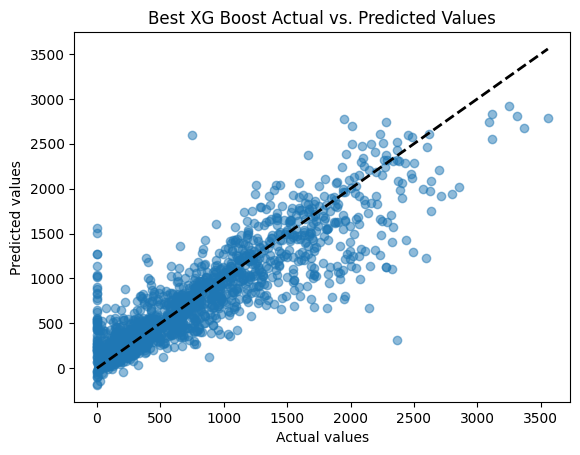

In [127]:
plot_pred_vs_actual(y_preds, "Best XG Boost Actual vs. Predicted Values")

## Stacking the Best Performers

In [128]:
pd.DataFrame(metrics)

,linear_regression,elasticnet,svr,best_rf_model,best_xgboost_model
model,linear_regression,elasticnet,svr,best_rf_model,best_xgboost_model
rmse,442.121151,486.088205,346.45915,306.484163,287.831634
cv_avg_rmse,436.450278,488.434415,336.559951,302.448496,285.456773
r2,0.530846,0.432896,0.711904,0.774551,0.801157


In [129]:

best_random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, min_samples_split=5,
                                    min_samples_leaf=1, max_depth=30,
                                    bootstrap=True, random_state=42))
])


best_xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(subsample=0.8, n_estimators=300, max_depth=7,
                           min_child_weight=3, learning_rate=0.1,
                           gamma=1, colsample_bytree=1.0, random_state=42))
])


# Define the stacking regressor
stacking_regressor = StackingRegressor(
    estimators=[
        ('random_forest', best_random_forest_pipeline),
        ('xgboost', best_xgboost_pipeline)
    ],
    final_estimator=LinearRegression(),
    cv=5
)


stacking_regressor.fit(X_train, y_train)

In [130]:
y_preds = get_metrics(stacking_regressor, "stack_model")

Model: stack_model
RMSE: 287.70
CV Avg RMSE: 284.87
R² Score: 0.80


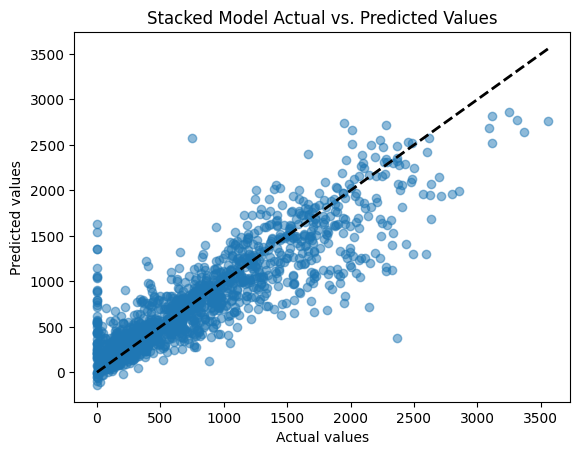

In [131]:
plot_pred_vs_actual(y_preds, "Stacked Model Actual vs. Predicted Values")

## Save Best Model

In [133]:
pd.DataFrame(metrics)

,linear_regression,elasticnet,svr,best_rf_model,best_xgboost_model,stack_model
model,linear_regression,elasticnet,svr,best_rf_model,best_xgboost_model,stack_model
rmse,442.121151,486.088205,346.45915,306.484163,287.831634,287.696198
cv_avg_rmse,436.450278,488.434415,336.559951,302.448496,285.456773,284.869683
r2,0.530846,0.432896,0.711904,0.774551,0.801157,0.801344


The best model is XGBoost, so let's save it.

In [134]:
import pickle

# Save the best model
with open('best_xg_boost_model.pkl', 'wb') as f:
    pickle.dump(best_xgboost_model, f)

## Summary

### Main Summary:
*   **Date Range:** The dataset is predominatly from 2018 with some data from 2017.
*   **Seasonal and Time-Based Trends:**
  
    - A majority of bikes are rented in the summer followed by spring and winter.
    - Most bikes are rented when the temparature is high.
    - There is a spike in bike rentals at the hours of 8AM and 6PM for all seasons.
    - Least popular times to rent a bike is is around 3-5 AM.
    - Least popular season to rent a bike is winter.
    - Bike rentals take a significant drop in the winter months for non-holidays and holidays.
*  **Holiday Data:** The slight decrease in bike rentals on holidays might be influenced by the limited holiday data available. More extensive data across multiple years would provide a clearer picture.
* Visibility has no strong direct correlation with bike rentals.

### Final Insight
So in summary most bikes are rented in the summmer with the sun is bright around 8AM and 6PM. I suggest having a low count of none functional bikes at those times at any season.  I also suggest doing maintenace on bikes in the winter months or around 3-5 AM in the Spring, Summer, and Fall months. This strategy could maximize the availability of bikes during peak demand times and minimize downtime during less popular periods.


### Specific Questions
- *What are the most significant factors influencing bike rental demand in Seoul?*

  The seasonal changes, the higher temparatures and commuting hours of 8AM and 6PM.

- *How do seasonal changes and weather conditions impact bike rental patterns?*

  Snowfall or rainfall further exacerbates the drop in rentals, alongside the temperature decreasing as the seasons change.

- *Are there any trends or patterns in bike rental usage during holidays or specific hours of the day?*

  There are spikes at commuting hours of 8AM and 6M for every season.  There is not enough data that covers the holidays to answer this question properly.  But it does seem to be a slight decrease in bike rentals on holidays.

- *How does air quality (visibility) affect bike rental behavior?*

  There is a very weak correlation which suggests that visibility is not a primary driver of bike rental behavior compared to temperature and time.
